# Building a Song Recommender
I always had an imense love for music and I figured to channel my appreiciation for music into data science and take a shot at making song recommendation. I am using Spotify's dataset from Kaggle. I will leave a link to the dataset in the README.md doc. 
I don't expect this to be a walk in the park, as this is a new problem for me. I have never built a song recommendation engine before so this will be interesting to figure out. 

## Setup
I am using Spotify's API to import my playlist into this notebook. https://developer.spotify.com/dashboard/login. Use my client ID and secert to run this notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spotipy
import spotipy.util as util
import xgboost as xgb

from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Musical Tempo
Music tempo is the amount of beats per minute or as known as BPM. Different music genres have different BPMs 
Generally speaking each of these genres have these equavlent BPMs

| Genre | Tempo/BPM |
| --- | --- |
| Reggae | 60-90 BPM |
| Hip-hop | 85-95 BPM|
| Pop | 100-130 BPM |
| Rock | 110 - 140 |
| Glitch hop | 105-115 BPM |
| House | 118-135 BPM |
| Tech House | 120-135 BPM |
| Techno | 120-125 BPM |
| Electro House | 125-130 BPM |
| Trance | 130-145 BPM |
| Dubstep | 140+ BPM |
| Drum & Bass | 165-185 BPM |


In [2]:
#Login and auth token
client = '17a64fb26bab4b6f96fbbb31a04ce3f9'
secret = '741506f6590a47fdb4aaa3a060ee4c6b'
username = 'Khalid'
redirect_uri = 'https://developer.spotify.com/dashboard/applications/17a64fb26bab4b6f96fbbb31a04ce3f9'
scope = 'user-library-read playlist-modify-public playlist-read-private'

client_cred_manager = SpotifyClientCredentials(client_id=client, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager= client_cred_manager)
token = util.prompt_for_user_token(username, scope, client, secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for username: ", username)

Load the playlist from our Spotify library using Spotipy's package into a dataframe. We're going to pull information about each song such as danceablity, energy, acousticness, etc. We will be using these features to run our model. To read more about these features use this link: https://developer.spotify.com/documentation/web-api/reference/object-model/#audio-features-object

In [3]:
def create_df(userID, playlistID):
    '''
    Function to get all songs of username from a specific playlistID and
    load it into a DF
    
    Args: 
        userID (str): Spotify username
        playlistID (str): Spotify playlist ID
        
    Return:
        playlist (pd DataFrame): dataframe of loaded playlist. 
    '''
    #load playlist
    good_playlist = sp.user_playlist(userID, playlistID)
    songs = good_playlist["tracks"]["items"]

    #an array of track ids (to find audio features) and create an array of song names
    track_ids = []
    song_names = []
    for i in songs:
        track_ids.append(i["track"]["id"])
        song_names.append(i["track"]["name"])

    #loop through to get audio features
    features = []
    for i in track_ids:
        for track in sp.audio_features(i):
            features.append(track)

    playlist_df = pd.DataFrame(features, index=song_names)
    return playlist_df

Load a couple of playlists into different dataframes and combine them in the end to the a mix of songs that I like. Do the same thing for songs that I dislike.

In [4]:
like_id = '4Bc92r2zL1zt22AikSodG4'
like_df = create_df(username, like_id)

like_playlist2_id = '5377x4KvJVl5Y4U6pakCf4'
like_playlist2_df = create_df(username, like_playlist2_id)

like_playlist3_id = '5CKGtvDsggH7g7UWhMqmSL'
like_playlist3_df = create_df(username, like_playlist3_id)

frames_like = [like_df, like_playlist2_df, like_playlist3_df]

like_all_df = pd.concat(frames_like)
like_all_df.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
TIME,0.00627,https://api.spotify.com/v1/audio-analysis/108r...,0.768,166000,0.808,108r6pnZHStBIktpyyps9w,0.000005,5,0.3430,-1.818,1,0.1120,119.971,4,https://api.spotify.com/v1/tracks/108r6pnZHStB...,audio_features,spotify:track:108r6pnZHStBIktpyyps9w,0.664
Falling - Radio Edit,0.00752,https://api.spotify.com/v1/audio-analysis/2jTJ...,0.446,230551,0.928,2jTJ9q2tLYJnElfIkiPwPZ,0.000019,0,0.5060,-6.482,0,0.0907,127.012,4,https://api.spotify.com/v1/tracks/2jTJ9q2tLYJn...,audio_features,spotify:track:2jTJ9q2tLYJnElfIkiPwPZ,0.239
Space Between,0.01220,https://api.spotify.com/v1/audio-analysis/72tb...,0.702,199921,0.595,72tb3B98H3vAZIyR2MLA6p,0.472000,11,0.1080,-8.295,0,0.0356,124.007,5,https://api.spotify.com/v1/tracks/72tb3B98H3vA...,audio_features,spotify:track:72tb3B98H3vAZIyR2MLA6p,0.483
Higher,0.00810,https://api.spotify.com/v1/audio-analysis/4uQz...,0.472,288189,0.881,4uQzfUUpSPtP8378Qg5aTo,0.111000,6,0.3660,-6.182,1,0.0491,127.014,4,https://api.spotify.com/v1/tracks/4uQzfUUpSPtP...,audio_features,spotify:track:4uQzfUUpSPtP8378Qg5aTo,0.240
Together,0.09850,https://api.spotify.com/v1/audio-analysis/48Cd...,0.461,287370,0.848,48CdOwO1Ense11v5a2Q4bm,0.000051,3,0.0784,-5.065,1,0.0692,128.009,4,https://api.spotify.com/v1/tracks/48CdOwO1Ense...,audio_features,spotify:track:48CdOwO1Ense11v5a2Q4bm,0.278


In [ ]:
like_all_df.info()

In [5]:
dislike_id = '37i9dQZF1DX1WSnLRtI26o'
dislike_df = create_df(username, dislike_id)

dislike_playlist2_id = '37i9dQZEVXbLRQDuF5jeBp'
dislike_playlist2_df = create_df(username, dislike_playlist2_id)

dislike_playlist3_id = '37i9dQZF1DWY4xHQp97fN6'
dislike_playlist3_df = create_df(username, dislike_playlist3_id)

frames_dislike = [dislike_df, dislike_playlist2_df, dislike_playlist3_df]

dislike_all_df = pd.concat(frames_dislike)
dislike_all_df.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
Electricity (with Dua Lipa),0.0104,https://api.spotify.com/v1/audio-analysis/5N4e...,0.588,238173,0.670,5N4erncE7kuUccm7zEmwzk,0.000003,0,0.3380,-6.439,1,0.0473,118.159,4,https://api.spotify.com/v1/tracks/5N4erncE7kuU...,audio_features,spotify:track:5N4erncE7kuUccm7zEmwzk,0.505
Close To Me (with Diplo) (feat. Swae Lee),0.0969,https://api.spotify.com/v1/audio-analysis/5JEx...,0.574,182623,0.758,5JEx7HbmvHQQswJCsoo9rA,0.000000,1,0.3950,-5.029,0,0.0621,144.111,4,https://api.spotify.com/v1/tracks/5JEx7HbmvHQQ...,audio_features,spotify:track:5JEx7HbmvHQQswJCsoo9rA,0.492
Remind Me to Forget,0.1930,https://api.spotify.com/v1/audio-analysis/5sIx...,0.685,217287,0.508,5sIx4BlfYGuZeSLF40N9GH,0.000000,0,0.1390,-6.400,1,0.0987,99.063,4,https://api.spotify.com/v1/tracks/5sIx4BlfYGuZ...,audio_features,spotify:track:5sIx4BlfYGuZeSLF40N9GH,0.315
Flames,0.0723,https://api.spotify.com/v1/audio-analysis/33IO...,0.609,195000,0.726,33IOhptvC2Qoy2UhjiHXLV,0.000008,5,0.0895,-4.346,0,0.0414,93.958,4,https://api.spotify.com/v1/tracks/33IOhptvC2Qo...,audio_features,spotify:track:33IOhptvC2Qoy2UhjiHXLV,0.362
Lost Without You,0.9280,https://api.spotify.com/v1/audio-analysis/6Eel...,0.409,225076,0.137,6EelrDeZGS0Z81NhXevtrJ,0.000000,6,0.0706,-9.169,1,0.0446,162.080,1,https://api.spotify.com/v1/tracks/6EelrDeZGS0Z...,audio_features,spotify:track:6EelrDeZGS0Z81NhXevtrJ,0.106


In [ ]:
dislike_all_df.info()

In [6]:
like_all_df = like_df.drop(columns=["analysis_url", "id", "track_href", "type", "uri"])
dislike_all_df = dislike_df.drop(columns=["analysis_url", "id", "track_href", "type", "uri"])

## Visualizing

Now that we have loaded our dataframes and removed features that won't help with modeling, let's visualize these features and comapred them with the liked and disliked.

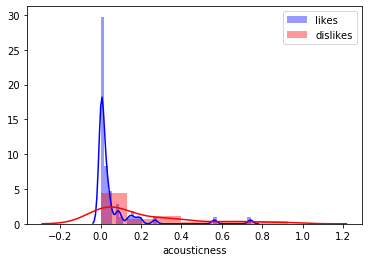

In [7]:
sns.distplot(like_all_df['acousticness'],color ='blue', label='likes')
sns.distplot(dislike_all_df['acousticness'], color ='r', label='dislikes')
plt.legend()
plt.show()

We can see that both dataframes do not have much acousticness to their properties. This means that a future recommended song will probably not have much acoustiness to it.

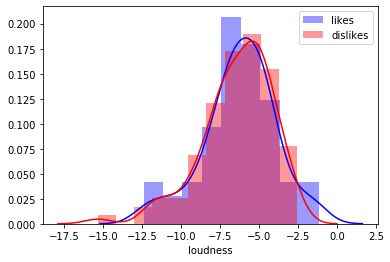

In [8]:
sns.distplot(like_all_df['loudness'],color ='blue', label='likes')
sns.distplot(dislike_all_df['loudness'], color ='r', label='dislikes')
plt.legend()
plt.show()

We can see for the loudness we have both disliked and liked songs that are in the negative zone, which means that these songs were't mixed or recorded with a high deceible. 

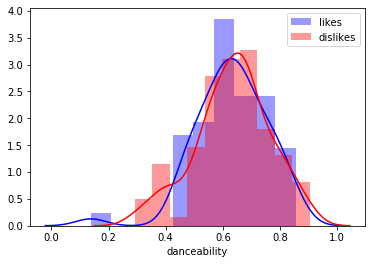

In [9]:
sns.distplot(like_all_df['danceability'],color ='blue', label='likes')
sns.distplot(dislike_all_df['danceability'], color ='r', label='dislikes')
plt.legend()
plt.show()

The distribution of liked danceable songs are mostly on 0.6, though there is a higher spread of disliked songs. 

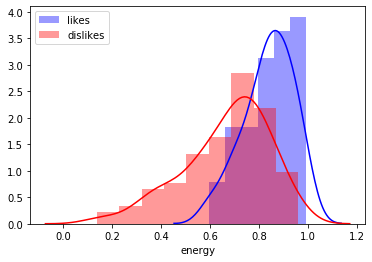

In [10]:
sns.distplot(like_all_df['energy'],color ='blue', label='likes')
sns.distplot(dislike_all_df['energy'], color ='r', label='dislikes')
plt.legend()
plt.show()

It seems that most of the songs that I liked have high energy, which is about right. I tend to enjoy music that excites me. This will indicate that my model will have a higher weight on the song's energy to recommend me a new song.

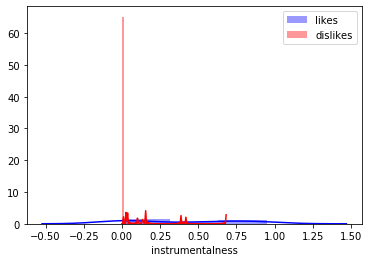

In [11]:
sns.distplot(like_all_df['instrumentalness'],color ='blue', label='likes')
sns.distplot(dislike_all_df['instrumentalness'], color ='r', label='dislikes')
plt.legend()
plt.show()

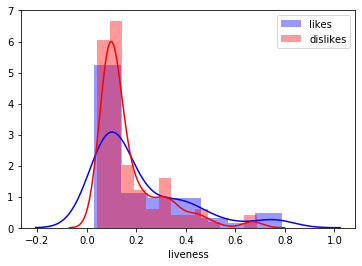

In [12]:
sns.distplot(like_all_df['liveness'],color ='blue', label='likes')
sns.distplot(dislike_all_df['liveness'], color ='r', label='dislikes')
plt.legend()
plt.show()

There are more disliked songs that are in the 0.0 and 0.2 range, and for liked tracks they are spread on the scale.

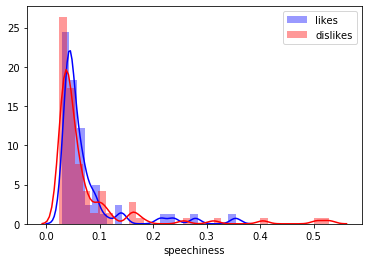

In [13]:
sns.distplot(like_all_df['speechiness'],color ='blue', label='likes')
sns.distplot(dislike_all_df['speechiness'], color ='r', label='dislikes')
plt.legend()
plt.show()

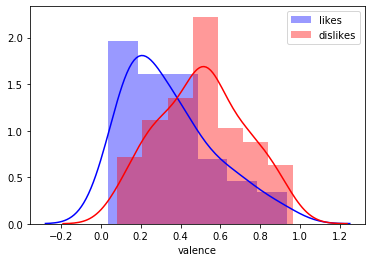

In [14]:
sns.distplot(like_all_df['valence'],color ='blue', label='likes')
sns.distplot(dislike_all_df['valence'], color ='r', label='dislikes')
plt.legend()
plt.show()

There seem to be more valence in songs that I dislike. This is odd, because I tend to lean more towards songs that are cheerful and happy. 

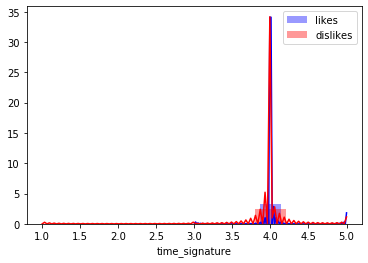

In [ ]:
sns.distplot(like_all_df['time_signature'],color ='blue', label='likes')
sns.distplot(dislike_all_df['time_signature'], color ='r', label='dislikes')
plt.legend()
plt.show()

## Feature Engineering
Let's add new features to our dataframes, we can improve our modeling score by add features such as expoclit lyics, popularity and then combining it all in one final dataframe.

In [ ]:
def find_popularity(userID, playlistID):
    '''
    Function to find song's popularity, pull this inforamtion from spotipy 
    
    Args:
        userID (str): Spotify's username
        playlistID (str): Spotifly's playlist ID
    returns:
        popularity (int): popularity score 0-100
    '''
    
    playlist = sp.user_playlist(userID, playlistID)
    songs = playlist["tracks"]["items"]
    popularity = []
    for i in songs:
        popularity.append(i["track"]["popularity"])
    return popularity

In [ ]:
like_popularity = find_popularity(username, like_id)
dislike_popularity = find_popularity(username, dislike_id)

In [ ]:
like_all_df['popularity'] = like_popularity
dislike_all_df['popularity'] = dislike_popularity
like_all_df.head()

In [ ]:
dislike_all_df.head()

In [ ]:
sns.distplot(like_all_df['popularity'], color='b', label='likes')
sns.distplot(dislike_all_df['popularity'], color='r', label='dislikes')
plt.legend()
plt.show()

In [ ]:
def find_explicit(userID, playlistID):
    '''
    Function to create an explicit feature pull from Spotify's API
    
    Args:
        userID (str): Spotify username
        playlistID (str): Spotify playlist ID
    
    return:
        explicit (Bool): If song is explicit = True else False
    '''
    playlist = sp.user_playlist(userID, playlistID)
    songs = playlist['tracks']['items']
    explicit = []
    for i in songs:
        explicit.append(i['track']['explicit'])
    return explicit

In [ ]:
like_explicit = find_explicit(username, like_id)
dislike_explicit = find_explicit(username, dislike_id)

In [ ]:
like_all_df['explicit'] = like_explicit
dislike_all_df['explicit'] = dislike_explicit
like_all_df.tail()

In [ ]:
dislike_all_df.head()

### Classification
Before combining our dataframes, create a feature to set a target variable which tells the model if we like the song or not. We are going to create a binary feature, which state if we like the song then show 1 else 0.

In [ ]:
# Add array of 1's to liked_df
like_all_df['like/dislike'] = [1] * (len(like_df))
dislike_all_df['like/dislike'] = [0] * (len(dislike_df))
like_all_df.head()

In [ ]:
#concate
train_data = pd.concat([like_all_df, dislike_all_df])
train_data

In [ ]:
#Plot correlation and see which features have a higher effect on our target variable
plt.figure(figsize=(12,12))
ax = sns.heatmap(train_data.corr(),annot=True , cmap='winter')

## Modeling
Now for the fun part. First we need to split out dataset into a train and test set. I am going to split the ratio to 70% training and 30% test. 

In [ ]:
train, test = train_test_split(train_data, test_size = 0.3, random_state = 42)
train.head()

In [ ]:
feats = ['acousticness', 'instrumentalness', 'liveness', 'loudness', 'energy', 
         'danceability', 'speechiness', 'valence', 'popularity', 'tempo']
X_train = train[feats]
y_train = train['like/dislike']
X_test = test[feats]
y_test = test['like/dislike']

### Logistic Regression

In [ ]:
#logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_test, y_test)

### K-nearest Neighbors

In [ ]:
#KNeighbors
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn.score(X_test, y_test)

### Random Forest Classification

In [ ]:
#RandomForest
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=2)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test)

### Decision Tree 

In [ ]:
#DecisonTree
dt = DecisionTreeClassifier(min_samples_split=90)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
dt.score(X_test, y_test)

### XGBoost

In [ ]:
#Xgboost
xg = xgb.XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.01, subsample=0.5)
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
xg.score(X_test, y_test)

In [ ]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

In [ ]:
dummy_pca = PCA(n_components=0.95, random_state=42).fit(X_train_scaled)

print("PCA has {} comps".format(dummy_pca.n_components_))
print("Variance is {}".format(sum(dummy_pca.explained_variance_ratio_)))